# Iterative Pruning: _LeNet-300-100_ on MNIST

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

In [2]:
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 1.7.1


In [3]:
# GPU device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Available device: {device}")

Available device: cpu


In [4]:
# Hyper-parameters-
input_size = 784    # 28 x 28, flattened to be 1-D tensor
hidden_size = 100
num_classes = 10
num_epochs = 20
batch_size = 32
learning_rate = 0.0012

In [5]:
os.chdir("/home/arjun/Documents/Programs/Python_Codes/PyTorch_Resources/Good_Codes/")

In [6]:
# MNIST dataset statistics:
# mean = tensor([0.1307]) & std dev = tensor([0.3081])
mean = np.array([0.1307])
std_dev = np.array([0.3081])

In [7]:
# Define data set transformations to apply-
transforms_apply = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std_dev)
    ])

In [8]:
# MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        root = './data', train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        root = './data', train = False,
        transform = transforms_apply
        )

In [9]:
print(f"len(train_dataset): {len(train_dataset)} & len(test_dataset): {len(test_dataset)}")

len(train_dataset): 60000 & len(test_dataset): 10000


In [10]:
# Create dataloader-
train_loader = torch.utils.data.DataLoader(
        dataset = train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test_dataset, batch_size = batch_size,
        shuffle = False
        )

In [11]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 1875 & len(test_loader) = 313


In [12]:
images, labels = next(iter(train_loader))

images.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [13]:
# Sanity check- one batch of data
examples = iter(train_loader)

# Unpack-
img_samples, labels = examples.next()
print(f"img_samples.shape = {img_samples.shape}, labels.shape = {labels.shape}")
# We have '1' due to grey-scale images.

img_samples.shape = torch.Size([32, 1, 28, 28]), labels.shape = torch.Size([32])


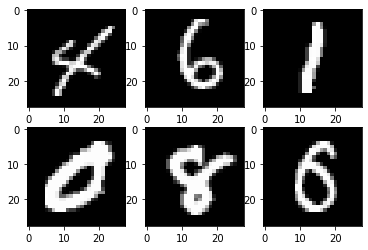

In [14]:
# images[0][0].shape      # the second index '0' accesses the 1st channel
# torch.Size([28, 28])

# Visualize the digits-
for i in range(6):
    plt.subplot(2, 3, i + 1)    # 2 rows & 3 columns
    plt.imshow(images[i][0], cmap = 'gray')     # '0' to access first channel
    # plt.imshow(img_samples[i][0], cmap='gray')  # '0' to access first channel
plt.show()

In [15]:
# Sanity check- Check whether transformations have been applied.
# Look at first image out of 32 images-
img_samples[0, :, :, :].min(), img_samples[0, :, :, :].max()

(tensor(-0.4242), tensor(2.8215))

In [16]:
class LeNet300(nn.Module):
    def __init__(self):
        super(LeNet300, self).__init__()
        
        # Define layers-
        self.fc1 = nn.Linear(in_features = input_size, out_features = 300)
        self.fc2 = nn.Linear(in_features = 300, out_features = 100)
        self.output = nn.Linear(in_features = 100, out_features = 10)
        
        self.weights_initialization()
    
    
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        return self.output(out)
    
    
    def weights_initialization(self):
        '''
        When we define all the modules such as the layers in '__init__()'
        method above, these are all stored in 'self.modules()'.
        We go through each module one by one. This is the entire network,
        basically.
        '''
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)


In [17]:
# Initialize an instance of LeNet-300-100 dense neural network-
model = LeNet300()

In [18]:
for name, param in model.named_parameters():
    # We do not prune bias term
    if 'weight' in name:
        print(f"layer name: {name}, has shape: {param.shape}")
    elif 'bias' in name:
        print(f"bias layer name: {name} has shape: {param.shape}")

layer name: fc1.weight, has shape: torch.Size([300, 784])
bias layer name: fc1.bias has shape: torch.Size([300])
layer name: fc2.weight, has shape: torch.Size([100, 300])
bias layer name: fc2.bias has shape: torch.Size([100])
layer name: output.weight, has shape: torch.Size([10, 100])
bias layer name: output.bias has shape: torch.Size([10])


In [19]:
# Define loss and optimizer-
loss = nn.CrossEntropyLoss()    # applies softmax for us
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
# Print optimizer's state_dict
print("Optimizer's 'state_dict':")
for var_name in optimizer.state_dict():
    print(f"var_name: {var_name} \t {optimizer.state_dict()[var_name]}")

In [20]:
# Training loop-
num_steps = len(train_loader)

print(f"num_steps = {num_steps} & len(train_dataset)/batch_size = {len(train_dataset) / batch_size}")
print(f"number of training steps in one epoch = {num_steps}")

num_steps = 1875 & len(train_dataset)/batch_size = 1875.0
number of training steps in one epoch = 1875


In [25]:
def count_params(model):
    
    tot_params = 0
    for layer_name, param in model.named_parameters():
        # print(f"{layer_name}.shape = {param.shape} has {torch.count_nonzero(param.data)} non-zero params")
        tot_params += torch.count_nonzero(param.data)
    
    return tot_params

### Train defined model:

In [21]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 5

# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
loc_patience = 0

In [22]:
# Python3 lists to store model training metrics-
training_acc = []
validation_acc = []
training_loss = []
validation_loss = []

In [23]:
def train_with_grad_freezing(model, epoch):
    '''
    Function to train one epoch of training dataset.
    '''
        
    running_loss = 0.0
    running_corrects = 0.0
        
    for batch, (images, labels) in enumerate(train_loader):
        # Reshape images first-
        # 32, 1, 28, 28
        # Input size needs to be 32, 784-
        images = images.reshape(-1, 28 * 28 * 1).to(device)
        # Tries to push to GPU if available
        labels = labels.to(device)
        # images, labels = images.reshape(-1, 28 * 28 * 1).to(device), labels.to(device)
        
        # Set defined model to training mode-
        model.train()
        
        # Backward pass-
        optimizer.zero_grad()   # empty accumulated gradients

        # Forward pass-
        outputs = model(images)

        # Compute loss-
        J = loss(outputs, labels)
        
        # Perform backpropagation-
        J.backward()
        
        # Freezing Pruned weights by making their gradients Zero
        for layer_name, param in model.named_parameters():
            if 'weight' in layer_name:
                tensor = param.data.cpu().numpy()
                grad_tensor = param.grad.data.cpu().numpy()
                # grad_tensor = np.where(tensor < EPS, 0, grad_tensor)
                grad_tensor = np.where(tensor == 0, 0, grad_tensor)
                param.grad.data = torch.from_numpy(grad_tensor).to(device)

        # Update parameters-
        optimizer.step()
        
        # Compute model's performance statistics-
        running_loss += J.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        running_corrects += torch.sum(predicted == labels.data)

        '''
        # Print information every 100 steps-
        if (batch + 1) % 100 == 0:
            print(f"epoch {epoch + 1}/{num_epochs}, step {batch + 1}/{num_steps}, loss = {J.item():.4f}")
        '''
        
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    
    return epoch_loss, epoch_acc
 


In [24]:
def test(model, epoch):
    '''
    Function to validate performance of trained 'model' on testing set.
    '''
    
    running_loss_val = 0.0

    total = 0
    correct = 0
    
    with torch.no_grad():
        for images, labels in test_loader:

            # Place features (images) and targets (labels) to GPU-
            # images = images.to(device)
            images = images.reshape(-1, 28 * 28 * 1).to(device)
            labels = labels.to(device)
            # images, labels = images.reshape(-1, 28 * 28 * 1).to(device), targets.to(device)
            # print(f"images.shape = {images.shape}, labels.shape = {labels.shape}")
            
            # Set model to evaluation mode-
            model.eval()
    
            # Make predictions using trained model-
            outputs = model(images)
            _, y_pred = torch.max(outputs, 1)

            # Compute validation loss-
            J_val = loss(outputs, labels)

            running_loss_val += J_val.item() * labels.size(0)
    
            # Total number of labels-
            total += labels.size(0)

            # Total number of correct predictions-
            correct += (y_pred == labels).sum()

    epoch_val_loss = running_loss_val / len(test_dataset)
    val_acc = 100 * (correct / total)
    
    return epoch_val_loss, val_acc

    

In [26]:
# Training loop-
for curr_epoch in range(1, num_epochs):
    
    if loc_patience >= patience:
        print("\n\nEarly stopping called. Exiting model training!\n\n")
        break
        
    # epoch_loss, epoch_acc = train(model = model, epoch = curr_epoch)
    epoch_loss, epoch_acc = train_with_grad_freezing(model = model, epoch = curr_epoch)
    epoch_val_loss, val_acc = test(model = model, epoch = curr_epoch)
    
    remaining_params = count_params(model)
    # Pruned LeNet-300-100 model has 226730 trainable parameters
    
    print(f"\nepoch: {curr_epoch}, # of params = {remaining_params}, training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%, val_loss = {epoch_val_loss:.4f} & val_accuracy = {val_acc:.2f}%\n")    
    # print(f"\nepoch: {curr_epoch} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%, val_loss = {epoch_val_loss:.4f} & val_accuracy = {val_acc:.2f}%\n")

    
    # Code for manual Early Stopping:
    # if np.abs(epoch_val_loss < best_val_loss) >= minimum_delta:
    if (epoch_val_loss < best_val_loss) and np.abs(epoch_val_loss - best_val_loss) >= minimum_delta:
        # print(f"epoch_val_loss = {epoch_val_loss:.4f}, best_val_loss = {best_val_loss:.4f}")
        
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = epoch_val_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0
        
        print(f"\nSaving model with lowest val_loss = {epoch_val_loss:.4f}")
        
        # Save trained model with validation accuracy-
        # torch.save(model.state_dict, f"LeNet-300-100_Trained_{val_acc}.pth")
        torch.save(model.state_dict(), "LeNet-300-100_Trained.pth")
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement


    training_acc.append(epoch_acc * 100)
    validation_acc.append(val_acc)
    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)
    


epoch: 1, # of params = 266610, training loss = 0.2036, training accuracy = 93.77%, val_loss = 0.1190 & val_accuracy = 96.21%


Saving model with lowest val_loss = 0.1190

epoch: 2, # of params = 266610, training loss = 0.0968, training accuracy = 97.04%, val_loss = 0.1003 & val_accuracy = 96.91%


Saving model with lowest val_loss = 0.1003

epoch: 3, # of params = 266610, training loss = 0.0738, training accuracy = 97.65%, val_loss = 0.1087 & val_accuracy = 96.67%


epoch: 4, # of params = 266610, training loss = 0.0608, training accuracy = 98.06%, val_loss = 0.0971 & val_accuracy = 97.31%


Saving model with lowest val_loss = 0.0971

epoch: 5, # of params = 266610, training loss = 0.0523, training accuracy = 98.36%, val_loss = 0.0992 & val_accuracy = 97.24%


epoch: 6, # of params = 266610, training loss = 0.0419, training accuracy = 98.65%, val_loss = 0.0917 & val_accuracy = 97.65%


Saving model with lowest val_loss = 0.0917

epoch: 7, # of params = 266610, training loss = 0.0387,

In [28]:
os.chdir("/home/arjun/Deep_Learning_Resources/LTH-Resources/")

In [29]:
# Initialize a new model for best weights achieved during training-
best_model = LeNet300()

In [30]:
best_model.load_state_dict(torch.load('LeNet-300-100_Trained.pth'))

<All keys matched successfully>

In [31]:
# Compute trained model's metrics on validation data-
val_loss, val_acc = test(model = best_model, epoch = 1)

In [32]:
print("\nLeNet-300-100 trained model metrics:")
print(f"val_loss = {val_loss:.4f} & val_accuracy = {val_acc:.2f}%")


LeNet-300-100 trained model metrics:
val_loss = 0.0917 & val_accuracy = 97.65%


In [33]:
# Delete 'model' since it's performance degraded due to 'patience' which led to over-fitting-
del model

In [34]:
def prune_lenet(model, pruning_params_fc, pruning_params_op):
    '''
    Function to prune top p% of trained weights using the provided parameters using
    magnitude-based weight pruning.
    
    Inputs:
    'model' is the PyTorch 1.7 defined neural network
    'pruning_params_fc' is the percentage of weights to prune for dense, fully-connected layer
    'pruning_params_op' is the percentage of weights to prune for output layer

    Returns:
    Python dict containing pruned layers
    '''
    
    # Python3 dict to hold pruned weights-
    pruned_d = {}
    
    # Sample code- populate each layer with relevant weights-
    for layer_name, param in best_model.named_parameters():
        # pruned_d[layer_name] = torch.zeros_like(param.data)
        x = param.data.numpy()
    
        if len(x.shape) == 2 and x.shape[0] != 10:
            # FC layer-
            # print(layer_name, param.shape)
    
            # Compute absolute value of 'x'-
            x_abs = np.abs(x)

            # Mask values to zero which are less than 'p' in terms of magnitude-
            x_abs[x_abs < np.percentile(x_abs, pruning_params_fc)] = 0

            # Where 'x_abs' equals 0, keep 0, else, replace with values of 'x'-
            # OR
            # If x_abs == 0 (condition) is True, use the value of 0, otherwise
            # use the value in 'x'
            x_mod = np.where(x_abs == 0, 0, x)
    
            # Counts the number of non-zero values in the array 'x_mod'-
            # np.count_nonzero(x_mod)
    
            # pruned_weights.append(x_mod)
            pruned_d[layer_name] = torch.from_numpy(x_mod)
    
        elif len(x.shape) == 2 and x.shape[0] == 10:
            # print("output layer", param.shape)
        
            # Output layer-
            # print(layer_name, param.shape)
    
            # Compute absolute value of 'x'-
            x_abs = np.abs(x)

            # Mask values to zero which are less than 'p' in terms of magnitude-
            x_abs[x_abs < np.percentile(x_abs, pruning_params_op)] = 0

            # Where 'x_abs' equals 0, keep 0, else, replace with values of 'x'-
            # OR
            # If x_abs == 0 (condition) is True, use the value of 0, otherwise
            # use the value in 'x'
            x_mod = np.where(x_abs == 0, 0, x)
    
            # Counts the number of non-zero values in the array 'x_mod'-
            # np.count_nonzero(x_mod)
    
            # pruned_weights.append(x_mod)
            pruned_d[layer_name] = torch.from_numpy(x_mod)
    
        else:
            pruned_d[layer_name] = param.data

    
    return pruned_d
    
    

In [43]:
# Prune 15% of smallest magnitude weights in FC layers and 10% in output layer-
pruned_d = prune_lenet(model = best_model, pruning_params_fc = 15, pruning_params_op = 10)

In [36]:
type(pruned_d)

dict

In [44]:
# Initialize and load pruned Python3 dict into a new model-
pruned_model = LeNet300()
pruned_model.load_state_dict(pruned_d)

<All keys matched successfully>

In [45]:
params_pruned = count_params(pruned_model)

In [46]:
print(f"# of non-zero parameters in pruned model = {params_pruned.numpy()}")

# of non-zero parameters in pruned model = 226730


### Re-train pruned model:

In [47]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 5

# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
loc_patience = 0

In [48]:
# Python3 lists to store model training metrics-
training_acc = []
validation_acc = []
training_loss = []
validation_loss = []

In [49]:
# Training loop-
for curr_epoch in range(1, num_epochs):
    
    if loc_patience >= patience:
        print("\n\nEarly stopping called. Exiting model training!\n\n")
        break
        
    # epoch_loss, epoch_acc = train(model = model, epoch = curr_epoch)
    epoch_loss, epoch_acc = train_with_grad_freezing(model = pruned_model, epoch = curr_epoch)
    epoch_val_loss, val_acc = test(model = pruned_model, epoch = curr_epoch)
    
    remaining_params = count_params(pruned_model)
    
    print(f"\nepoch: {curr_epoch}, # of params = {remaining_params}, training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%, val_loss = {epoch_val_loss:.4f} & val_accuracy = {val_acc:.2f}%\n")    
    # print(f"\nepoch: {curr_epoch} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%, val_loss = {epoch_val_loss:.4f} & val_accuracy = {val_acc:.2f}%\n")

    
    # Code for manual Early Stopping:
    # if np.abs(epoch_val_loss < best_val_loss) >= minimum_delta:
    if (epoch_val_loss < best_val_loss) and np.abs(epoch_val_loss - best_val_loss) >= minimum_delta:
        # print(f"epoch_val_loss = {epoch_val_loss:.4f}, best_val_loss = {best_val_loss:.4f}")
        
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = epoch_val_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0
        
        print(f"\nSaving model with lowest val_loss = {epoch_val_loss:.4f}")
        
        # Save trained model with validation accuracy-
        # torch.save(model.state_dict, f"LeNet-300-100_Trained_{val_acc}.pth")
        torch.save(pruned_model.state_dict(), "LeNet-300-100_Test_Trained.pth")
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement


    training_acc.append(epoch_acc * 100)
    validation_acc.append(val_acc)
    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)
    


epoch: 1, # of params = 226730, training loss = 0.0285, training accuracy = 99.04%, val_loss = 0.0910 & val_accuracy = 97.68%


Saving model with lowest val_loss = 0.0910

epoch: 2, # of params = 226730, training loss = 0.0285, training accuracy = 99.04%, val_loss = 0.0910 & val_accuracy = 97.68%


epoch: 3, # of params = 226730, training loss = 0.0285, training accuracy = 99.04%, val_loss = 0.0910 & val_accuracy = 97.68%


epoch: 4, # of params = 226730, training loss = 0.0285, training accuracy = 99.04%, val_loss = 0.0910 & val_accuracy = 97.68%


epoch: 5, # of params = 226730, training loss = 0.0285, training accuracy = 99.04%, val_loss = 0.0910 & val_accuracy = 97.68%


epoch: 6, # of params = 226730, training loss = 0.0285, training accuracy = 99.04%, val_loss = 0.0910 & val_accuracy = 97.68%



Early stopping called. Exiting model training!


